In [17]:
# Basic Imports
import numpy as np
import h5py as h5
#from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle
import re
import collections
import tables as tb
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.style.use('ggplot')

In [20]:
# Data imports
rsfc = pd.read_csv('/projects/jp/DS-classifier/raw/rsfc-dti-spins.csv')
rsfc.rename(columns={u'Unnamed: 0': 'ID'}, inplace=True)

pds = pd.read_csv('/projects/jp/DS-classifier/raw/pds-dti-spins.csv')
pds.drop('Unnamed: 0', axis=1, inplace=True)
merged = pd.merge(rsfc, pds, on='ID', how='left')

# add in deficit status
#quantiles = np.percentile(merged['PDS'], np.arange(0, 100, 25))
#merged.loc[merged.PDS >= quantiles[3], 'defstat'] = 'D'
#merged.loc[merged.PDS < quantiles[1], 'defstat'] = 'N'
#merged.defstat = merged.defstat

#Find quantiles from finite data
merged['defstat'] = -1
merged_finite = merged[np.isfinite(merged['PDS'])]
maxB = np.max(np.array(merged_finite['PDS']))
minB = np.min(np.array(merged_finite['PDS']))
LB = merged_finite['PDS'].quantile(0.33)
HB = merged_finite['PDS'].quantile(0.67)

merged.loc[merged.PDS >= HB, 'defstat'] = 0
merged.loc[merged.PDS < LB, 'defstat'] = 1
merged.DX.fillna("H", inplace=True)

In [21]:
# Select specific rows and cols (tasks and models)
task = 'PDS'

if task == 'PDS':
    merged_clean = merged[np.isfinite(merged[task])] #Remove NaNs for PDS    
    model_clf = RandomForestRegressor(n_jobs=8)
    regression = True

if task == 'DX':    
    merged_clean = merged 
    model_clf = RandomForestClassifier(n_jobs=8)
    regression = False
    
if task == 'defstat':    
    merged_clean = merged[merged['defstat']!= -1] #Remove NaNs
    model_clf = RandomForestClassifier(n_jobs=8)
    regression = False
    
hyper_params = {'n_estimators':[10,50,100,200],'min_samples_split':[2,4,8]}
s = 1
e = 35779
X = np.array(merged_clean.ix[:,s:e].copy()) #Select Cols
y = np.array(merged_clean[task])
print 'X shape: {}, y shape: {}, D v ND ratio: {}'.format(X.shape, y.shape, float(np.sum(y))/y.shape[0])

X shape: (97, 35778), y shape: (97,), D v ND ratio: -5.0206185567


In [26]:
# Run Configs
inner_loop = True
save_model = False
save_model_path = './'
test_subset_fraction = 0.2

# Sample train test subsets (outerfold)
rand_state = 0
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx1, idx2 = cross_validation.train_test_split(X, y, indices, test_size=test_subset_fraction, random_state=rand_state)

#run model:
results = computeOuterFold(X_train, y_train, X_test, y_test, model_clf, regression, hyper_params, inner_loop, save_model, save_model_path)

#Post hoc Classifcation
pred_scores = results['predicted_fold_score']
class_labels = merged['defstat'][idx2]
class_thresh_dict = {0:(HB,maxB),1:(minB,LB),-1:(LB,HB)}
pred_classes = postHoc_Classification(pred_scores, class_labels, class_thresh_dict)
cm = confusion_matrix(class_labels, pred_classes, labels=None)

#print zip(pred_classes, class_labels)
print 'Classification Acc based on thresholded PDS prediciton: {}'.format(np.sum(pred_classes == class_labels)/float(len(class_labels)))
print 'Confusion Matrix: {}'.format(cm) 

Starting Outerfold computation
Starting Inner computation
Ending InnerFold computation
Ending OuterFold computation
Classification Acc based on thresholded PDS prediciton: 0.55
Confusion Matrix: [[11  0  2]
 [ 5  0  0]
 [ 2  0  0]]


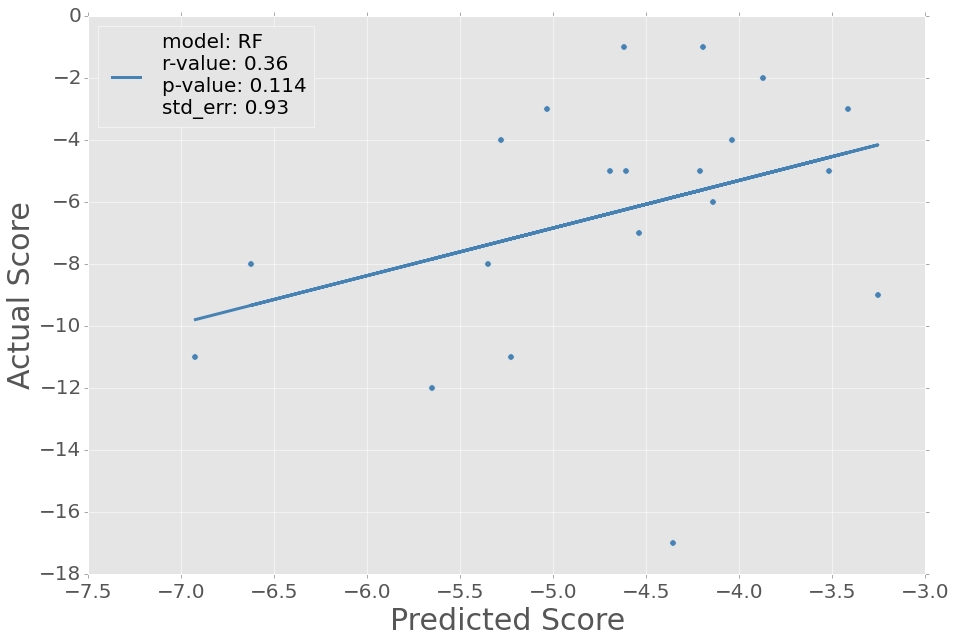

In [27]:
# Fancy Plots
# Formatting configs
from matplotlib.artist import setp
plt.rcParams['figure.figsize'] = (15, 10)
font_small = 20
font_med = 30
font_large = 40
my_colors = ['steelblue', 'olivedrab', 'cadetblue', 'salmon']

x_plt = pred_scores
y_plt = y_test

k=0
plt.scatter(x_plt, y_plt, c=my_colors[k], s=40)
fit = np.polyfit(x_plt,y_plt,1)
fit_fn = np.poly1d(fit) 
slope, intercept, r_value, p_value, std_err = stats.linregress(x_plt,y_plt)
if p_value < 0.0001:
    p_value_sig = '<0.001'
else:
    p_value_sig = '{:.3}'.format(p_value)

#Plot annotations
label_str = 'model: {}'.format('RF') + '\n' + 'r-value: {:04.2f}'.format(r_value) + '\n' + 'p-value: ' + p_value_sig + '\n' + 'std_err: {:04.2f}'.format(std_err) 
# fit_fn is now a function which takes in x and returns an estimate for y
plt.plot(x_plt, fit_fn(x_plt),linewidth=3, c=my_colors[k], label=label_str)
#plt.title(model_choice,fontsize=font_large)
#plt.set_ylim(0,40)
plt.xlabel('Predicted Score',fontsize=font_med)
plt.ylabel('Actual Score',fontsize=font_med)            
plt.legend(fontsize=font_small,loc=2)
plt.tick_params(labelsize=font_small)


[[16  0  2]
 [ 1  0  0]
 [ 1  0  0]]


In [5]:
# Need imports within the defs if using ipython parallelization. 
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y,save_model,save_model_path):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)
    #Save classifier
    if save_model:
        save_model(clf,save_model_path)
        
    return clf

#Outer Fold Computation
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, regression, hyper_params, inner_loop, save_model, save_model_path):
    import collections
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting Inner computation'
        save_model_path_fold = save_model_path + '_fold_' 
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y,save_model,save_model_path_fold)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
        
    #CV_scores    
    CV_stats = {}
    if regression:    
        r_train = stats.pearsonr(clf.predict(train_X),train_y)
        r_valid = stats.pearsonr(clf.predict(valid_X),valid_y)

        R2_train = clf.score(train_X,train_y) 
        R2_valid = clf.score(valid_X,valid_y)

        MSE_train = mse(clf.predict(train_X),train_y)
        MSE_valid = mse(clf.predict(valid_X),valid_y)
        
        CV_stats = {'r_valid':r_valid, 'R2_valid':R2_valid, 'MSE_valid':MSE_valid}
        
    else: 
        class_acc = clf.score(valid_X,valid_y)
        CV_stats = {'class_acc':class_acc}
    
    print 'Ending OuterFold computation'
    
    return {'CV_stats':CV_stats, 'hp_dict':hp_dict, 'predicted_fold_score': clf.predict(valid_X), 'actual_fold_scores':valid_y}

def postHoc_Classification(pred_scores, class_labels, class_thresh_dict):
    # class_thresh_dict: {0:(0,-2), 1:(-7,-15)} labels and their correspnding ranges
    pred_classes = []
    label_matched = False
    for score in pred_scores:
        for key in class_thresh_dict.keys():
            T_L = class_thresh_dict[key][0]
            T_H = class_thresh_dict[key][1]
            if T_L <= score < T_H:
                pred_classes.append(key)
                label_matched = True
                break
                
    if not label_matched:
        print "Incorrect class thresholds..."
        
    return pred_classes
    

In [ ]:
#Scratch Work
merged_finite = merged[np.isfinite(merged['PDS'])]
print np.median(np.array(merged_finite['PDS']))
print merged_finite['PDS'].quantile(0.25)
print merged_finite['PDS'].quantile(0.75)